# Final Project for MLSS
## How good can models forget old definitions and remember new ones?
Contributors: </br>
Ayrton San Joaquin </br>
Ardy Haroen

## Import Dependencies

In [38]:
!pip install spacy ftfy==4.4.3
!python -m spacy download en
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.2 MB/s 
  Created wheel for ftfy: filename=ftfy-4.4.3-py3-none-any.whl size=41082 sha256=81c73f81dc5a2d6686e492c3a5aee0bc54807aabc0030f15a53e729e23413120
  Stored in directory: /root/.cache/pip/wheels/b0/66/08/c65b9e8a3b674f10739790db0cbbc846afaa20a3f80f0b9e42
Successfully built ftfy
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 23.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [43]:
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, GPT2Config, OpenAIGPTTokenizer, OpenAIGPTLMHeadModel, OpenAIGPTModel, OpenAIGPTConfig
from torch.nn import CosineSimilarity
import torch

In [3]:
# comment this cell if you don't want to mount your drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Build Dataset

In [ ]:
!pip install datasets 
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

Find the K=300 most popular words with antonyms in the bookcorpus dataset.

Consists of 150 adjectives and 150 verbs.

In [ ]:
from nltk.corpus import wordnet as wn

'''
Given N words and their corresponding antonyms,
the dictionaries are each of length 2N pairs.
'''


# key: word, value: antonym
adj_antonyms, verb_antonyms = {}, {}
for i in wn.all_synsets():
    # Ref: https://wordnet.princeton.edu/documentation/wndb5wn
    # If synset is adj or satelite-adj. kwarg doesn't support lists...
    if i.pos() in ["a", "s"]:
      for j in i.lemmas():
          # If adj has antonym AND is not already in the dict
          if j.antonyms(): 
              adj_antonyms[j.name().replace("_", " ")] =  j.antonyms()[0].name().replace("_", " ")

# if synset is verb
for i in wn.all_synsets(pos="v"): 
    for j in i.lemmas():
          # If adj has antonym
          if j.antonyms(): 
              verb_antonyms[j.name().replace("_", " ")] =  j.antonyms()[0].name().replace("_", " ")

In [ ]:
# Load HuggingFace
from datasets import load_dataset
# Run once
corpus_dset = load_dataset("bookcorpus", split="train")

Generating train split:   0%|          | 0/74004228 [00:00<?, ? examples/s]

Dataset bookcorpus downloaded and prepared to /root/.cache/huggingface/datasets/bookcorpus/plain_text/1.0.0/eddee3cae1cc263a431aa98207d4d27fd8a73b0a9742f692af0e6c65afa4d75f. Subsequent calls will reuse this data.


In [ ]:
'''
Count the frequency of adjectives and verbs in the dataset
'''

verb_counter, adj_counter = {}, {}
# searching the entire dataset is infeasible
# it has 74004228 lines!

# O(N^2)
N = 40000
for ds in tqdm(corpus_dset[:N]["text"]):
  for adj in adj_antonyms.keys():
    count = re.split("\W+", ds.lower()).count(adj)
    adj_counter[adj] = \
         count if adj not in adj_counter.keys() \
         else adj_counter[adj] + count

adjs_df = pd.DataFrame(sorted(adj_counter.items(), key=lambda item: item[1]), 
                      columns=["adjectives", "a_count"])
# sanity check
print(adjs_df.tail())

100%|██████████| 40000/40000 [14:05<00:00, 47.34it/s]

     adjectives  a_count
3376       back     2070
3377       just     2100
3378        out     2503
3379         up     2680
3380         on     3207


In [ ]:
int(len(adjs_df)/10)

338

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f40f0582110>]],
      dtype=object)

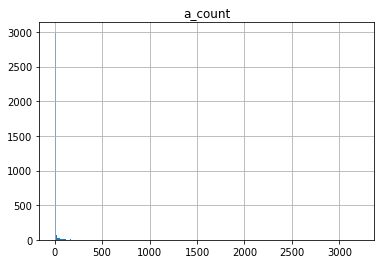

In [ ]:
# Very few words dominate frequency (Long tailed distribution)
adjs_df.hist(bins=int(len(adjs_df)/10))

In [ ]:
'''
EXPLAI

We want one example per word, so frequency = 1
'''
K = 300
min_freq, max_freq = 1, 2 
top_adjs = adjs_df[ (adjs_df["a_count"] >= min_freq) & (adjs_df["a_count"] <= max_freq) ]["adjectives"][-K:].tolist()
print(len(top_adjs))

300


In [ ]:
# Get 1 text/sentence for each word and replace it with its antonym
antonym_texts, orig_texts = [], []

for word in tqdm(top_adjs):
  for curr_text in corpus_dset[:N]["text"]:
    if word in re.split("\W+", curr_text.lower()):
      orig_texts.append(curr_text)
      for adj in top_adjs:
        string=r'\b'+adj+r'\b' # \b - start and end of the  word
        curr_text=re.sub(string, adj_antonyms[adj], curr_text)
      antonym_texts.append(curr_text)
      break

assert len(antonym_texts) == K

100%|██████████| 300/300 [00:41<00:00,  7.30it/s]


In [ ]:

red = lambda x: f'\x1b[31m{x}\x1b[0m'

def highlight_diff(text1, text2, format_func):
    shared_toks = set(text1.split(' ')) & set(text2.split(' '))
    return ' '.join([format_func(tok) if tok not in shared_toks else tok for tok in text1.split(' ') ])

highlight_diff(antonym_texts[0], orig_texts[0], red)

"`` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the \x1bintelligent\x1b comments gary had mouthed during the dinner ."

In [ ]:
orig_texts[0]

"`` well said , '' mr. meyers replied , the first time he revealed that he was fully aware of all the unintelligent comments gary had mouthed during the dinner ."

In [ ]:
# sanity check
print(*antonym_texts[145:155], sep='\n')
print('\n')
print(*orig_texts[145:155], sep='\n')

`` if you 're alluding to the fact you accidentally got drunk last night and then became well , that has little relevance to me .
instead , they 'd wheelless her in , and pesh had gone to work .
`` guess my heart is just too pure and unwholesome for my own good , '' i kid , fluttering my eyelashes daintily .
and bear with me because i 've been considering this all afternoon while you sat here and looked like the sexiest woman alive so there might be a few re-entrant points to work out .
there 's a pretty olive-skinless girl standing on the curb who turns her head as nate calls out , `` natasha ! ''
each time he went a little deeper , and it caused megan to be more and more instrumental .
one of the designs victoria had unposed in had caught the eye of a magazine editor and there was the possibility of a layout for the following spring .
she extended the least unabused hand , which , thankfully , was her right one .
i 'll be lenient with you when it comes to certain things , but outrigh

In [ ]:
np.save("antonym_txt.npy", antonym_texts)
np.save("orig_txt.npy", orig_texts)

### Data Statistics

In [ ]:
import numpy as np

antonym_texts = np.load("cleaned_antonym_txt.npy")
orig_texts = np.load("cleaned_orig_txt.npy")

antonym_lengths = [len(antonym_texts[i].split()) for i in range(len(antonym_texts))]
orig_lengths = [len(orig_texts[i].split()) for i in range(len(orig_texts))]

np.median(orig_lengths), np.mean(antonym_lengths), np.mean(orig_lengths), np.sum(orig_lengths)

(20.0, 21.406666666666666, 21.406666666666666, 6422)

#### Appendix: Problem with Verbs

The phrase "Ides of March" turn into "Ides of Walk". We cannot distinguish between (1) verbs used as nouns and nouns that exactly match a verb from (2) verbs used as verbs

In [ ]:
# Dataset for VErbs (problem)

for verb in verb_antonyms.keys():
    # must match word
    count = re.split("\W+", ds.lower()).count(verb)
    # Note else statement is equal to += op
    verb_counter[verb] = \
         count if verb not in verb_counter.keys() \
         else verb_counter[verb] + count

verbs_df = pd.DataFrame(sorted(verb_counter.items(), key=lambda item: item[1]), 
                      columns=["verbs", "v_count"])

top_verbs = verbs_df[ (verbs_df["v_count"] >= min_freq) & (verbs_df["v_count"] <= max_freq) ]["verbs"][-K//2:].tolist()


for word in tqdm(top_verbs):
  for curr_text in corpus_dset[:N]["text"]:
    if word in re.split("\W+", curr_text.lower()):
      orig_texts.append(curr_text)
      # prevents examples from having old definitions
      for verb in top_verbs:
        string=r'\b'+verb+r'\b' # \b - start and end of the  word
        curr_text = re.sub(string, verb_antonyms[verb], curr_text)
        
      antonym_texts.append(curr_text)
      break

### Turn numpy dumps into txt dumps

In [ ]:
with open("cleaned_antonym_txt.txt", "w+") as outfile:
  for a in antonym_texts:
    outfile.write(f"{a}\n")

## Fine-tune on Models

In [4]:
# Load exported data

file_id1 = "12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK"
file_id2 = "1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ"
file_id3 = "1n-IWpjxi_eVRFAXj79DReBMHZZg8F0Sc"
file_id4 = "1sq1SZ7iOmDobHmoFpHVVISAbZn2sDH27"
file_id5 = "1E23mzLrKl59sUhABixmAAAdKFYMO40jw"

!gdown "$file_id1"
!gdown "$file_id2"
!gdown "$file_id3"
!gdown "$file_id4"
!gdown "$file_id5"

antonym_texts = np.load("cleaned_antonym_txt.npy")
orig_texts = np.load("cleaned_orig_txt.npy")

Downloading...
From: https://drive.google.com/uc?id=12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK
To: /content/cleaned_orig_txt.npy
100% 457k/457k [00:00<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ
To: /content/cleaned_antonym_txt.npy
100% 460k/460k [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n-IWpjxi_eVRFAXj79DReBMHZZg8F0Sc
To: /content/run_clm.py
100% 25.0k/25.0k [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sq1SZ7iOmDobHmoFpHVVISAbZn2sDH27
To: /content/run_clm_no_trainer.py
100% 27.9k/27.9k [00:00<00:00, 43.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E23mzLrKl59sUhABixmAAAdKFYMO40jw
To: /content/cleaned_antonym_txt.txt
100% 32.1k/32.1k [00:00<00:00, 42.9MB/s]


In [5]:
gpt2_model_path = "gpt2-antonyms"
gpt_model_path = "gpt-antonyms"

In [ ]:
# finetune GPT2
!python run_clm.py \
  --model_name_or_path gpt2 \
  --train_file cleaned_antonym_txt.txt \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --do_train \
  --overwrite_output_dir \
  --output_dir "$gpt2_model_path"

In [ ]:
# finetune GPT

!python run_clm.py \
  --model_name_or_path openai-gpt \
  --train_file cleaned_antonym_txt.txt \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --do_train \
  --overwrite_output_dir \
  --output_dir "$gpt_model_path"

In [44]:
'''
m1 = orig model (i.e. pretrained)
m2 = finetuned model
'''
# GPT
## m1
gpt_m1_tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
gpt_m1 = OpenAIGPTModel.from_pretrained("openai-gpt")
## m2
gpt_m2_tokenizer = OpenAIGPTTokenizer.from_pretrained(gpt_model_path)
gpt_m2 = OpenAIGPTModel.from_pretrained(gpt_model_path)

# GPT2
## m1
gpt2_m1_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_m1 = GPT2Model.from_pretrained("gpt2")
## m2
gpt2_m2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
gpt2_m2 = GPT2Model.from_pretrained(gpt2_model_path)

Some weights of the model checkpoint at drive/MyDrive/finetuned-models-mlss/gpt-antonyms were not used when initializing OpenAIGPTModel: ['lm_head.weight']
- This IS expected if you are initializing OpenAIGPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OpenAIGPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at drive/MyDrive/finetuned-models-mlss/gpt2-antonyms were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
-

## Evaluate Model's Adaptability to new Definition

### Define Score Function

In [45]:
import torch

def score(tokenizer, model, text1, text2, model_type):
  """
  Params:
  - model_type is either "gpt" or "gpt2"
  """
  if model_type not in ["gpt", "gpt2"]:
    print("Error: model_type is either 'gpt' or 'gpt2'")
    return
  
  idx1 = tokenizer.encode(text1)
  idx2 = tokenizer.encode(text2)
  
  vec1, vec2 = None, None
  if model_type == "gpt":
    vec1 = model.tokens_embed.weight[idx1, :]
    vec2 = model.tokens_embed.weight[idx2, :]
  if model_type == "gpt2":
    vec1 = model.wte.weight[idx1, :]
    vec2 = model.wte.weight[idx2, :]
  
  # sentences can have diff lengths
  return torch.norm(vec1.mean(dim=0) - vec2.mean(dim=0), dim=-1)

def delta_score(m1_scores, m2_scores):
  return np.array(m1_scores) - np.array(m2_scores)

K=300
'''
Compare models
Calc delta score. Higher means better.
'''

# GPT
# vector of scores
gpt_m1_scores = [score(gpt_m1_tokenizer, gpt_m1, antonym_texts[i], orig_texts[i], "gpt").detach().numpy() for i in range(K)]
gpt_m2_scores = [score(gpt_m2_tokenizer, gpt_m2, antonym_texts[i], orig_texts[i], "gpt").detach().numpy() for i in range(K)]
gpt_delta_score = delta_score(gpt_m1_scores, gpt_m2_scores)

# GPT2

gpt2_m1_scores = [score(gpt2_m1_tokenizer, gpt2_m1, antonym_texts[i], orig_texts[i], "gpt2").detach().numpy() for i in range(K)]
gpt2_m2_scores = [score(gpt2_m2_tokenizer, gpt2_m2, antonym_texts[i], orig_texts[i], "gpt2").detach().numpy() for i in range(K)]
gpt2_delta_score = delta_score(gpt2_m1_scores, gpt2_m2_scores)

In [46]:
# average delta scores
f"gpt delta mean: {gpt_delta_score.mean()}", f"gpt2 delta mean: {gpt2_delta_score.mean()}"

('gpt delta mean: 2.1652516807080247e-05',
 'gpt2 delta mean: 2.0563005818985403e-05')

### Plots

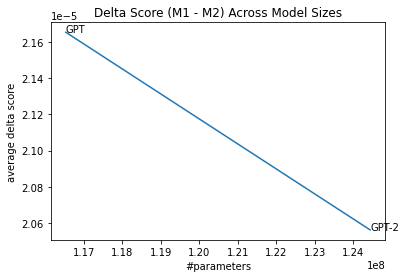

In [55]:
num_params = [gpt_m1.num_parameters(), gpt2_m1.num_parameters()]
score_means = [gpt_delta_score.mean(), gpt2_delta_score.mean()]
annot = ['GPT', 'GPT-2']

fig, ax = plt.subplots()

ax.plot(
    num_params, 
    score_means,
    '-'
)
plt.title("Delta Score (M1 - M2) Across Model Sizes")
plt.xlabel("#parameters")
plt.ylabel("average delta score")

for i in range(len(num_params)):
  ax.annotate(annot[i], (num_params[i], score_means[i]))